# Imports

In [31]:
import utils
import optuna
import inspect
import warnings
import numpy as np
import pandas as pd

from umap import UMAP

from scipy.stats import ks_2samp
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, BaseCrossValidator
from sklearn.datasets import make_regression

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [17]:
warnings.filterwarnings("ignore")

## Functions

In [18]:
def generate_synthetic_regression_data(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    noise=0.2,
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera dados sintéticos para problemas de regressão.
    
    Parâmetros
    ----------
    n_samples : int
        Número total de observações a serem geradas.
    n_features : int
        Número total de variáveis preditoras.
    n_informative : int
        Número de variáveis realmente informativas (as outras serão ruído).
    noise : float
        Nível de ruído adicionado à variável resposta.
    test_size : float
        Proporção da base reservada para teste.
    valid_size : float
        Proporção da base de treino reservada para validação.
    random_state : int
        Semente para reprodutibilidade.
    
    Retorna
    -------
    X_train, y_train, X_valid, y_valid, X_test, y_test : pd.DataFrame
        Bases de treino, validação e teste.
    """

    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        random_state=random_state
    )

    # Cria DataFrames nomeados
    feature_names = [f"feature_{i}" for i in range(n_features)]
    X = pd.DataFrame(X, columns=feature_names)
    y = pd.DataFrame(y, columns=["target"])

    # Divide em treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Divide parte de treino em treino/validação
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=valid_size, random_state=random_state
    )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [19]:
def get_params_space(model_name, trial, random_state=42):
    match model_name:
        case 'LightGBM':
            return {
                'objective': trial.suggest_categorical('objective', ['regression']),
                'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
                'metric': trial.suggest_categorical('metric', ['rmse', 'mae', 'mape', 'mse']),
                'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                'random_state': trial.suggest_categorical('random_state', [random_state]),
                'verbose': trial.suggest_categorical('verbose', [-1])
            }
        case 'CatBoost':
            return {
                'loss_function': trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),
                'iterations': trial.suggest_int('iterations', 100, 1000, step=100),
                'depth': trial.suggest_int('depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
                'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
                'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
                'border_count': trial.suggest_int('border_count', 32, 255),
                'rsm': trial.suggest_float('rsm', 0.5, 1.0),
                'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
                'boosting_type': trial.suggest_categorical('boosting_type', ['Plain']),
                'random_seed': trial.suggest_categorical('random_seed', [random_state]),
                'verbose': trial.suggest_categorical('verbose', [0])
            }
        case 'HistGradientBoosting':
            return {
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
                'max_iter': trial.suggest_int('max_iter', 100, 1000, step=100),
                'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20, 255),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 100),
                'l2_regularization': trial.suggest_float('l2_regularization', 1e-4, 10.0, log=True),
                'early_stopping': trial.suggest_categorical('early_stopping', [False]),
                'scoring': trial.suggest_categorical('scoring', ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']),
                'validation_fraction': trial.suggest_float('validation_fraction', 0.1, 0.4),
                'n_iter_no_change': trial.suggest_int('n_iter_no_change', 5, 20),
                'random_state': trial.suggest_categorical('random_state', [random_state])
            }
        case 'RandomForest':
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'random_state': trial.suggest_categorical('random_state', [random_state]),
                'n_jobs': trial.suggest_categorical('n_jobs', [-1])
            }
        case 'GradientBoosting':
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber']),
                'random_state': trial.suggest_categorical('random_state', [random_state])
            }
        case 'ExtraTrees':
            return {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 3, 30),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
                'criterion': trial.suggest_categorical('criterion', ['squared_error', 'absolute_error']),
                'random_state': trial.suggest_categorical('random_state', [random_state]),
                'n_jobs': trial.suggest_categorical('n_jobs', [-1])
            }
        case _:
            raise ValueError(f"Model '{model_name}' is not supported.")

In [20]:
def get_model_instance(model_name):
    match model_name:
        case 'LightGBM':
            return LGBMRegressor
        case 'CatBoost':
            return CatBoostRegressor
        case 'HistGradientBoosting':
            return HistGradientBoostingRegressor
        case 'XGBoost':
            return XGBRegressor
        case 'RandomForest':
            return RandomForestRegressor
        case 'GradientBoosting':
            return GradientBoostingRegressor
        case 'ExtraTrees':
            return ExtraTreesRegressor
        case _:
            raise ValueError(f"Model '{model_name}' is not suported.")

## Data Base

In [25]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_regression_data(
    n_samples=500000,
    n_features=20,
    n_informative=8,
    noise=5.0
)

In [35]:
from scipy.stats import ks_2samp

In [69]:
import numpy as np
import pandas as pd

def calculate_psi(base, sample, bins=10):
    """
    Calculates the Population Stability Index (PSI) between the base and the sample.
    Works for both numerical and categorical variables.
    
    Parameters
    ----------
    base : array-like
        Original population (reference distribution).
    sample : array-like
        Sample population to compare against the base.
    bins : int, optional (default=10)
        Number of bins for numerical variables.
        
    Returns
    -------
    psi : float
        The PSI value:
            < 0.1   -> no significant change
            0.1–0.25 -> small change
            > 0.25  -> significant change
    """

    # Convert to pandas Series to make categorical handling easier
    base = pd.Series(base).dropna()
    sample = pd.Series(sample).dropna()

    # --- Case 1: Numerical variable ---
    if np.issubdtype(base.dtype, np.number):
        # Define breakpoints using base percentiles
        breakpoints = np.percentile(base, np.linspace(0, 100, bins + 1))
        base_counts, _ = np.histogram(base, bins=breakpoints)
        sample_counts, _ = np.histogram(sample, bins=breakpoints)

        base_perc = base_counts / len(base)
        sample_perc = sample_counts / len(sample)

    # --- Case 2: Categorical variable ---
    else:
        base_counts = base.value_counts(normalize=True)
        sample_counts = sample.value_counts(normalize=True)

        # Align categories to avoid mismatched indices
        all_cats = set(base_counts.index).union(set(sample_counts.index))
        base_perc = np.array([base_counts.get(cat, 0) for cat in all_cats])
        sample_perc = np.array([sample_counts.get(cat, 0) for cat in all_cats])

    # --- Common PSI formula ---
    base_perc = np.where(base_perc == 0, 0.0001, base_perc)
    sample_perc = np.where(sample_perc == 0, 0.0001, sample_perc)

    psi = np.sum((base_perc - sample_perc) * np.log(base_perc / sample_perc))
    return psi

np.float64(4.7481775286602735e-06)

In [73]:
results['representativa']

IndexError: invalid index to scalar variable.

In [9]:
rfe = SequentialFeatureSelector(
    XGBRegressor(verbose=-1), 
    n_features_to_select=15, 
    direction='backward',
    scoring='neg_root_mean_squared_error', 
    cv=3
)
rfe.fit(X_train, y_train['target'])
best_features_reg = X_train.loc[:, rfe.get_support()].columns.tolist()

# Regressor

In [11]:
class AutoMLRegressor:
    def __init__(
        self, X_train, y_train, X_valid, y_valid, X_test, y_test, model_name, target='target', 
        scoring='r2', cv=None, features=None, tune=False, params_space=None, n_trials=50, random_state=42):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        self.cv = cv
        self.tune = tune
        self.target = target
        self.n_trials = n_trials
        self.model_name = model_name
        self.model_instance = get_model_instance(model_name)
        self.features = features if features else self.X_train.columns.tolist()
        self.scorer = utils.get_reg_eval_scoring(scoring, return_func=False)
        self.func_metric = utils.get_reg_eval_scoring(scoring, return_func=True)
        self.random_state = random_state

    def _get_best_params(self):
        def objective(trial):
            params = get_params_space(self.model_name, trial, self.random_state)
            model = self.model_instance(**params)
            if isinstance(self.cv, (int, BaseCrossValidator)):
                cv_results = cross_validate(
                    estimator=model, 
                    X=self.X_train[self.features],
                    y=self.y_train[self.target],
                    cv=self.cv,
                    scoring=self.scorer
                )
                return np.mean(cv_results['test_score'])
            
            model.fit(self.X_train[self.features], self.y_train[self.target])
            preds = model.predict(self.X_valid[self.features])
            return self.func_metric(self.y_valid[self.target], preds)
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=self.n_trials)
        return study.best_params
    
    def _cross_validate(self, model):
        cv_results = cross_validate(
            estimator=model, 
            X=self.X_train[self.features], 
            y=self.y_train[self.target],
            cv=self.cv,
            scoring=(
                'r2', 
                'neg_mean_absolute_error', 
                'neg_median_absolute_error', 
                'neg_mean_absolute_percentage_error', 
                'neg_root_mean_squared_error', 
                'explained_variance'
            )
        )
        return {
            'R2': cv_results['test_r2'].mean(),
            'MAE': np.abs(cv_results['test_neg_mean_absolute_error'].mean()),
            'MadAE': np.abs(cv_results['test_neg_median_absolute_error'].mean()),
            'MAPE': np.abs(cv_results['test_neg_mean_absolute_percentage_error'].mean()),
            'RMSE': np.abs(cv_results['test_neg_root_mean_squared_error'].mean()),
            'Explained Variance': cv_results['test_explained_variance'].mean()
        }
    
    def _fit(self):
        model_sig = inspect.signature(self.model_instance).parameters
        init_params = {}
        if 'random_state' in model_sig:
            init_params['random_state'] = self.random_state
        if 'verbose' in model_sig:
            init_params['verbose'] = 0
        elif 'verbosity' in model_sig:
            init_params['verbosity'] = -1

        params = self._get_best_params() if self.tune else init_params
        model = self.model_instance(**params)

        if isinstance(self.cv, (int, BaseCrossValidator)):
            results = {'Train CV': self._cross_validate(model)}
            model.fit(self.X_train[self.features], self.y_train[self.target])
            self.y_test['pred'] = model.predict(self.X_test[self.features])
            results['Test'] = utils.get_reg_metrics(self.y_test, 'pred', self.target)
            return model, results

        fit_sig = inspect.signature(model.fit).parameters
        fit_args = {'X': self.X_train[self.features], 'y': self.y_train[self.target]}
        if 'eval_set' in fit_sig and self.X_valid is not None:
            fit_args['eval_set'] = [(self.X_valid[self.features], self.y_valid[self.target])]
        if 'early_stopping_rounds' in fit_sig:
            fit_args['early_stopping_rounds'] = 50

        model.fit(**fit_args)

        self.y_train['pred'] = model.predict(self.X_train[self.features])
        self.y_valid['pred'] = model.predict(self.X_valid[self.features])
        self.y_test['pred'] = model.predict(self.X_test[self.features])

        results = {
            'Train': utils.get_reg_metrics(self.y_train, 'pred', self.target),
            'Valid': utils.get_reg_metrics(self.y_valid, 'pred', self.target),
            'Test': utils.get_reg_metrics(self.y_test, 'pred', self.target)
        }
        return model, results

    def train(self):
        self.model, self.results = self._fit()

    def get_metrics(self, return_df=True):
        return pd.DataFrame(self.results).T if return_df else self.results
    
    def get_result_analysis(self):
        display(self.get_metrics())
        utils.analyze_model(
            self.model, self.features, 
            self.X_train, self.y_train, self.y_test, self.target, self.scorer
        )

## Base Model

In [9]:
a = AutoMLRegressor(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test, 
    y_test,
    model_name='GradientBoosting'
)

In [10]:
a.train()

In [11]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.987870,13.825250,11.572763,0.631653,17.513965,0.987870
Valid,0.955406,26.113708,21.506315,1.123470,33.414016,0.955566
Test,0.957037,26.567323,23.608962,0.722634,33.711357,0.957087


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.987870,13.825250,11.572763,0.631653,17.513965,0.987870
Valid,0.955406,26.113708,21.506315,1.123470,33.414016,0.955566
Test,0.957037,26.567323,23.608962,0.722634,33.711357,0.957087


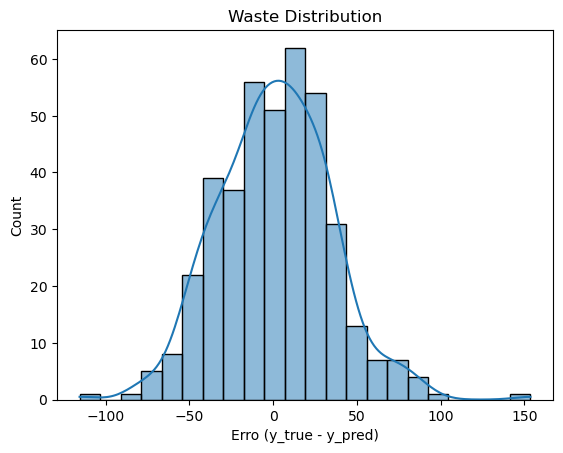

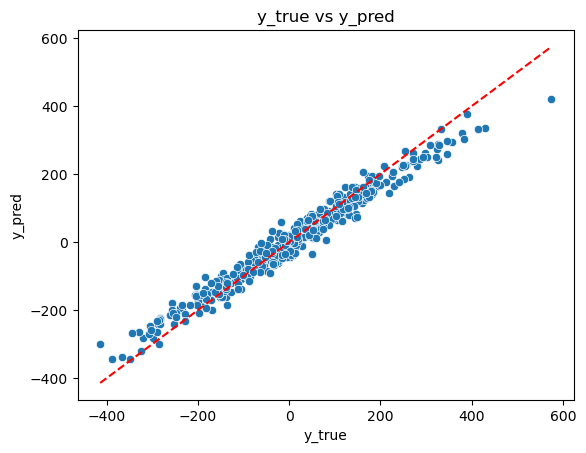

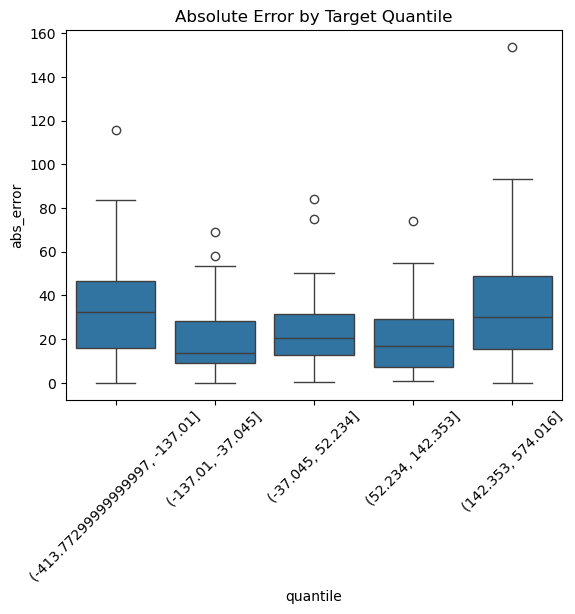

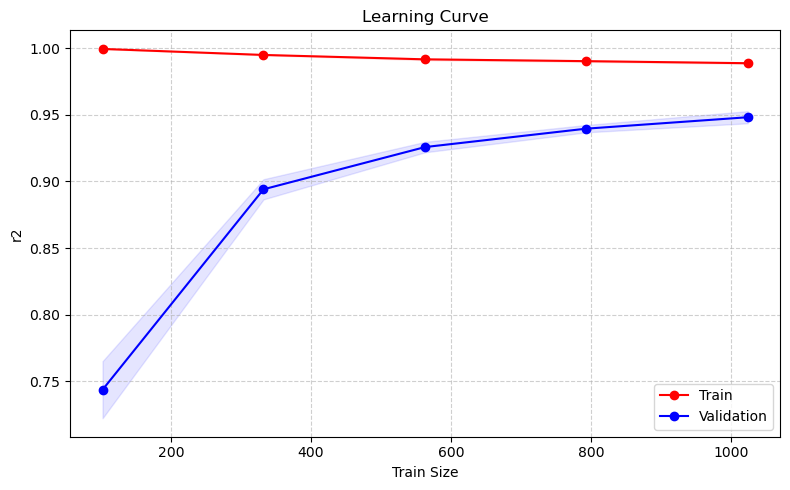

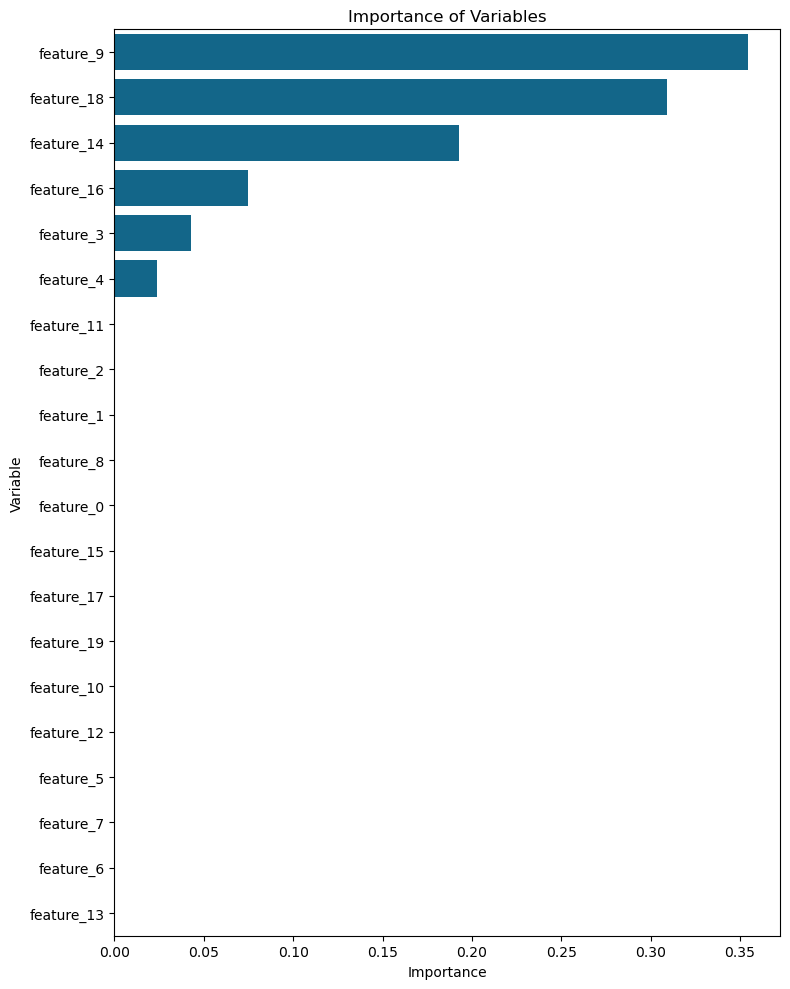

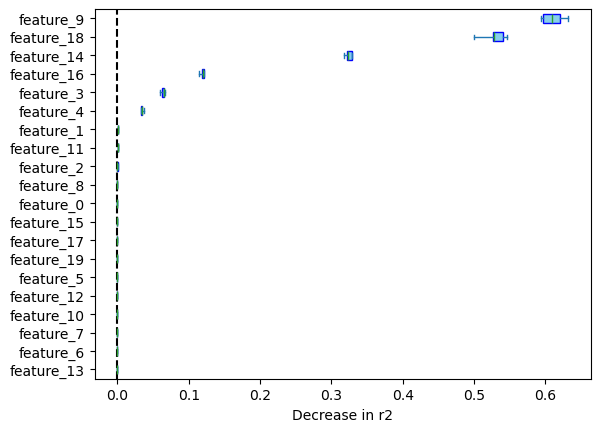

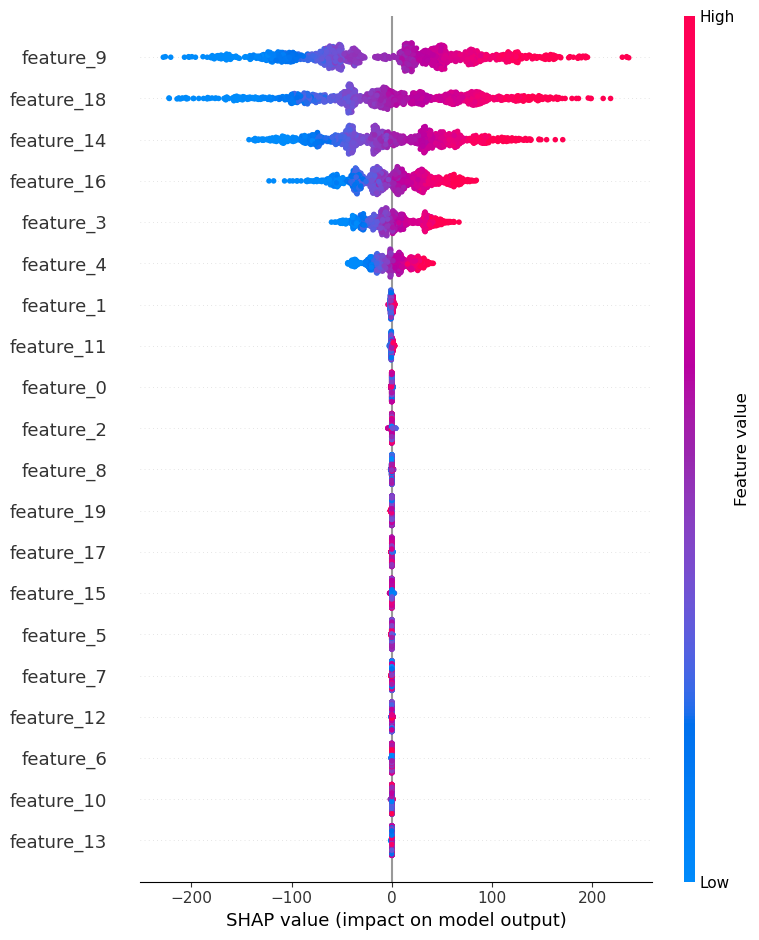

In [12]:
a.get_result_analysis()

## Feature Selection Model

In [13]:
a = AutoMLRegressor(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test,
    y_test,
    model_name='RandomForest',
    features=best_features_reg
)

In [14]:
a.train()

In [15]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.983000,15.807843,12.537656,0.832753,20.734311,0.983002
Valid,0.871103,45.316049,36.339934,1.834786,56.808140,0.871677
Test,0.877059,43.778865,35.899688,1.293248,57.026445,0.878096


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.983000,15.807843,12.537656,0.832753,20.734311,0.983002
Valid,0.871103,45.316049,36.339934,1.834786,56.808140,0.871677
Test,0.877059,43.778865,35.899688,1.293248,57.026445,0.878096


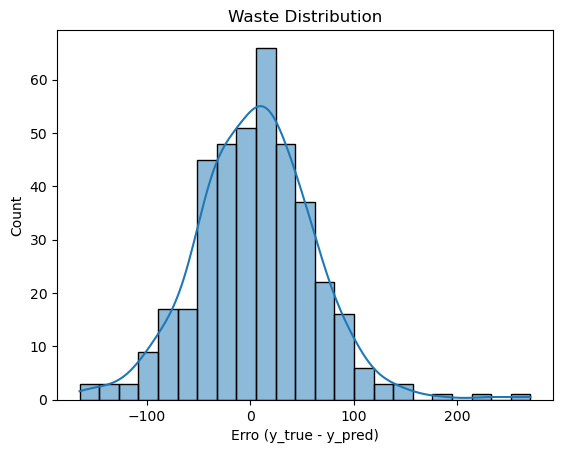

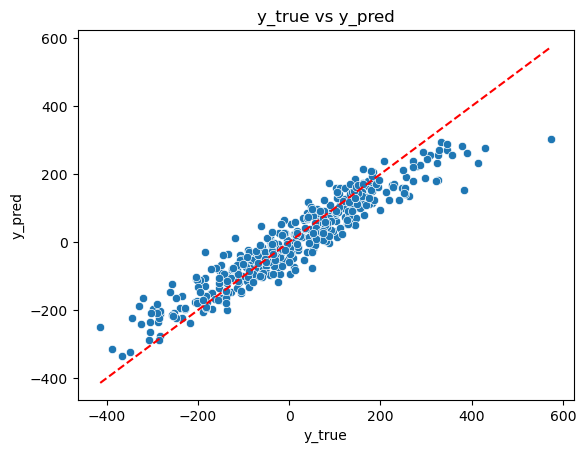

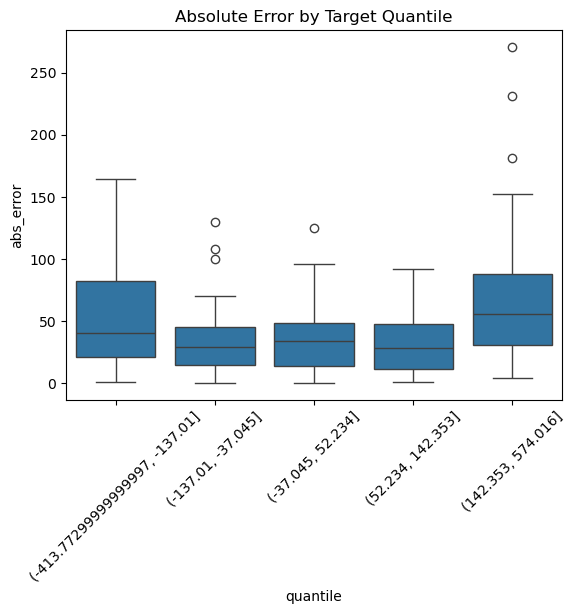

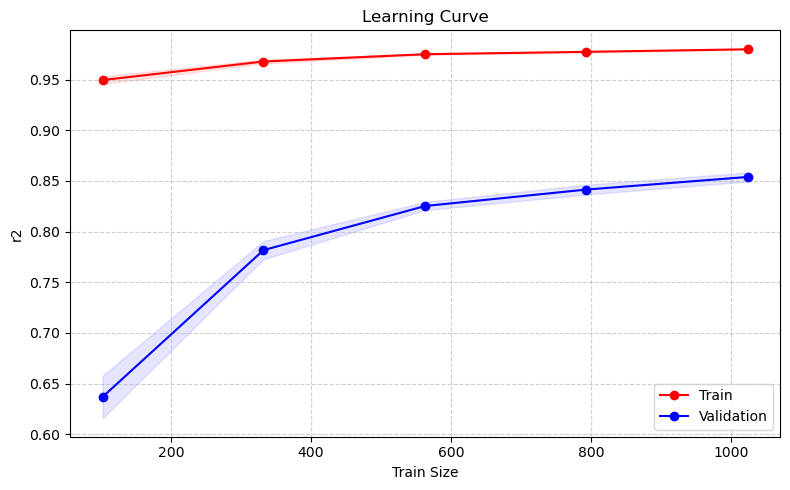

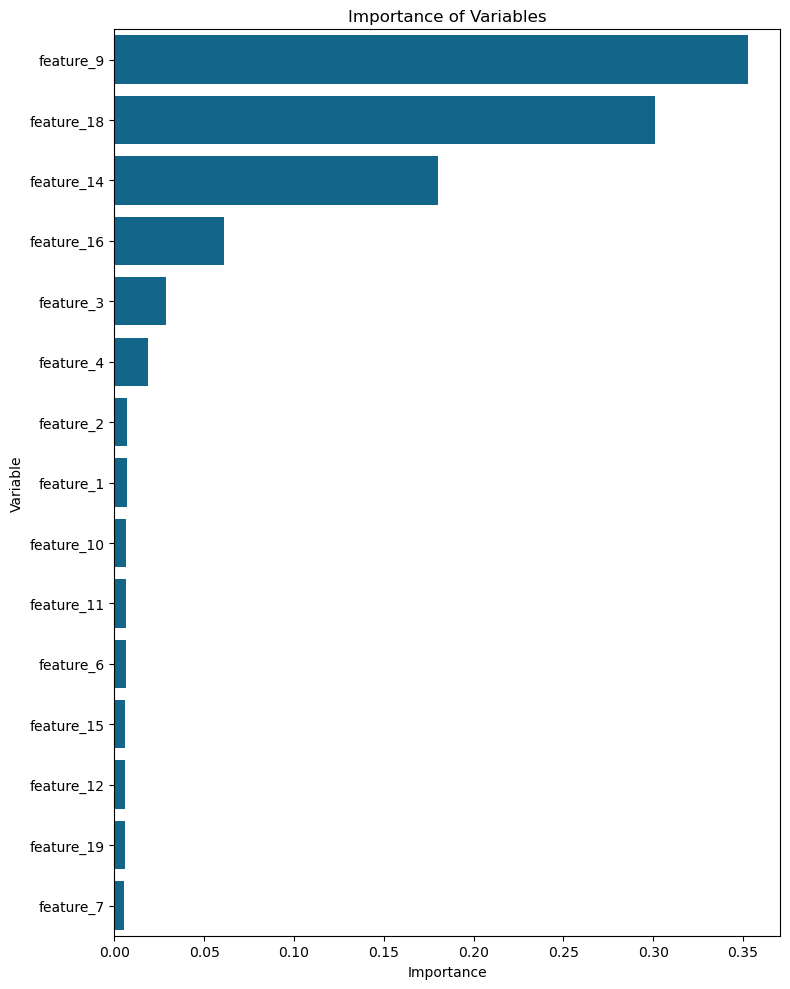

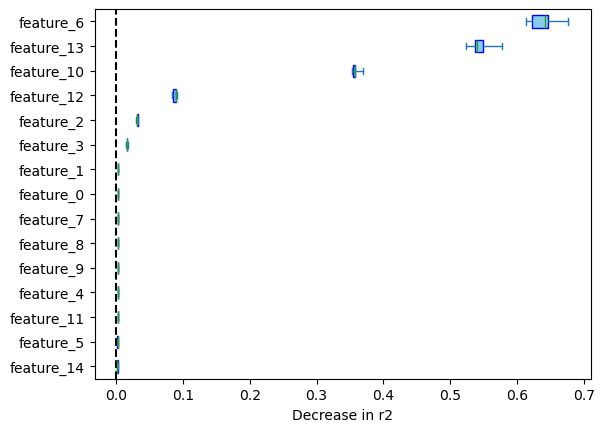

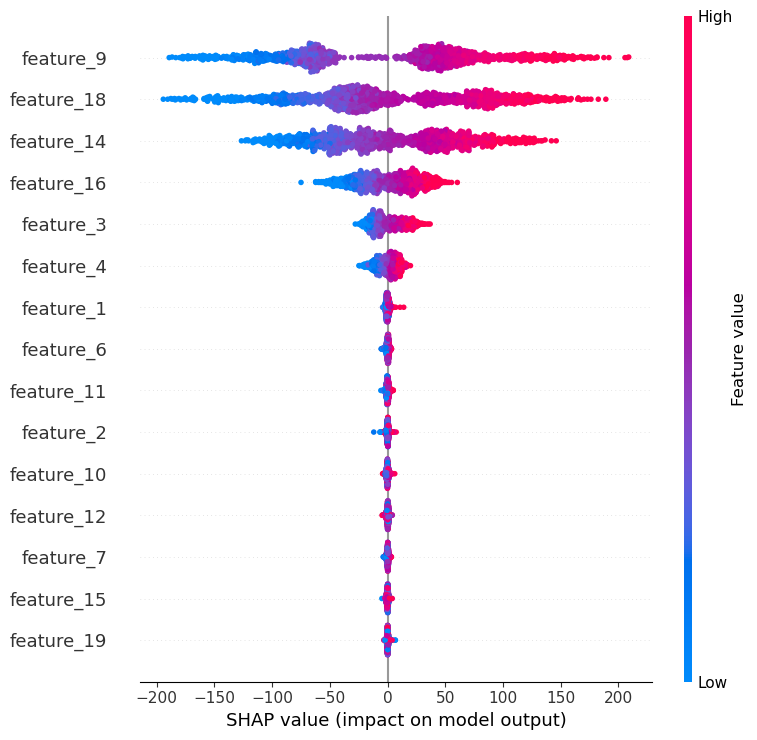

In [16]:
a.get_result_analysis()

## Hiperparameter Fine Tuning

In [17]:
a = AutoMLRegressor(
    X_train, 
    y_train, 
    X_valid, 
    y_valid,
    X_test,
    y_test,
    model_name='HistGradientBoosting',
    tune=True,
    features=best_features_reg,
)

In [18]:
a.train()

In [19]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.999509,1.962916,1.250929,0.195073,3.523898,0.999509
Valid,0.969812,20.347398,15.822235,0.728277,27.492048,0.969835
Test,0.965050,21.475380,15.806802,0.433684,30.405602,0.965098


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train,0.999509,1.962916,1.250929,0.195073,3.523898,0.999509
Valid,0.969812,20.347398,15.822235,0.728277,27.492048,0.969835
Test,0.965050,21.475380,15.806802,0.433684,30.405602,0.965098


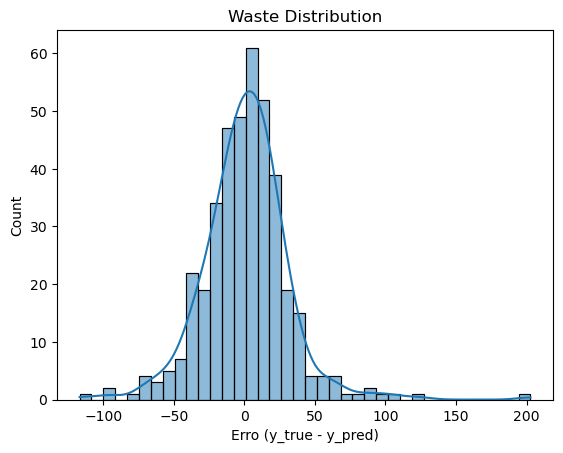

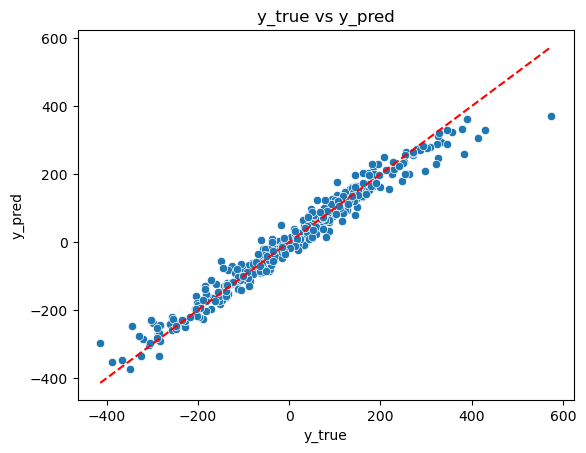

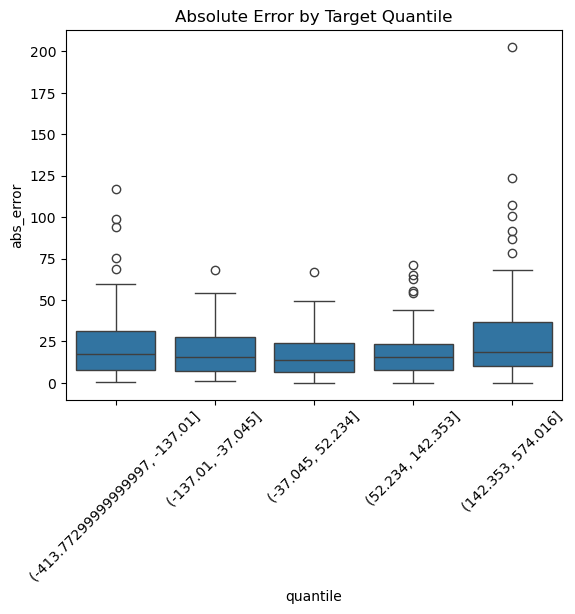

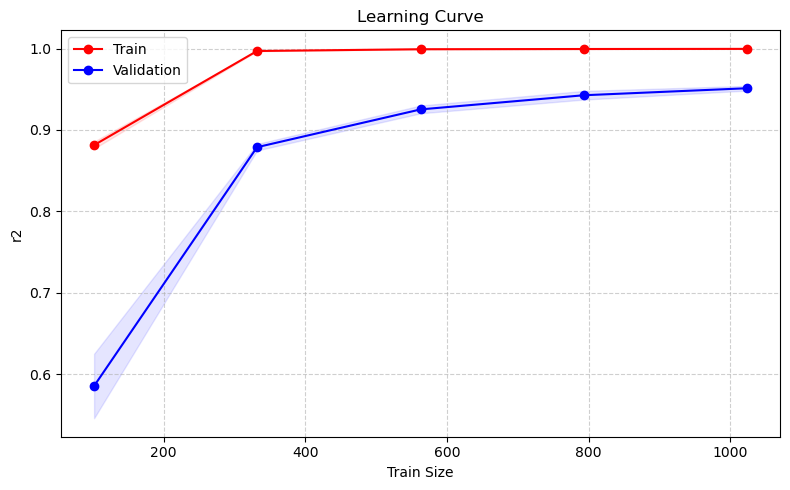

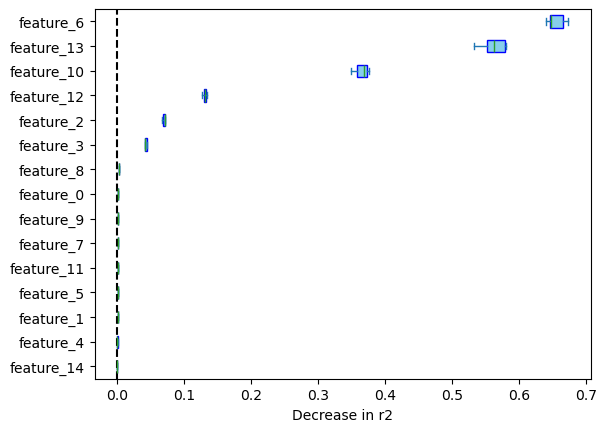

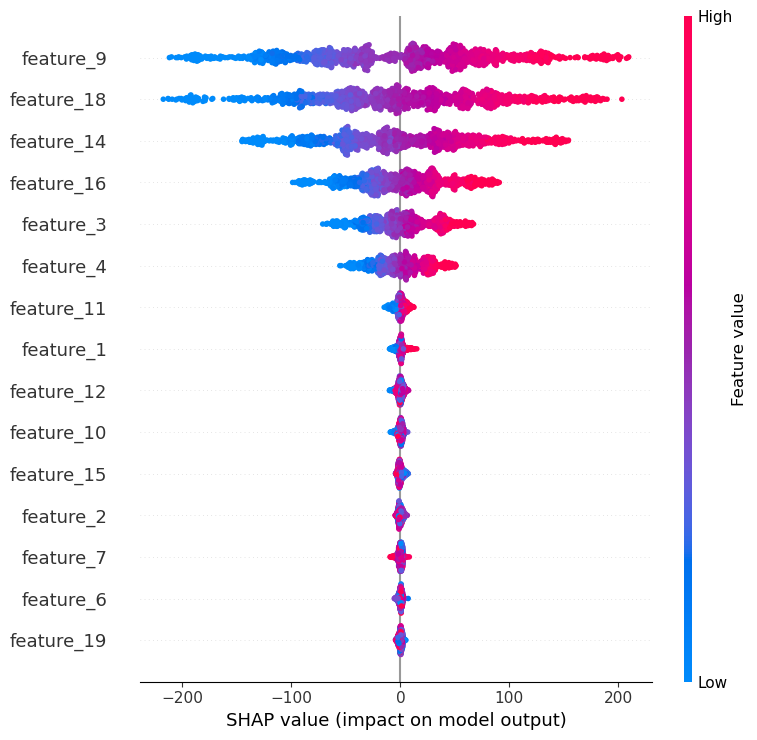

In [20]:
a.get_result_analysis()

## Base Model (CV)

In [24]:
a = AutoMLRegressor(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    model_name='CatBoost',
    target='target',
    scoring='root_mean_squared_error'
)

In [25]:
a.train()

In [26]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.985173,12.929174,9.136447,0.952260,19.284740,0.985196
Test,0.986194,12.658399,8.924886,0.268898,19.110106,0.986302


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.985173,12.929174,9.136447,0.952260,19.284740,0.985196
Test,0.986194,12.658399,8.924886,0.268898,19.110106,0.986302


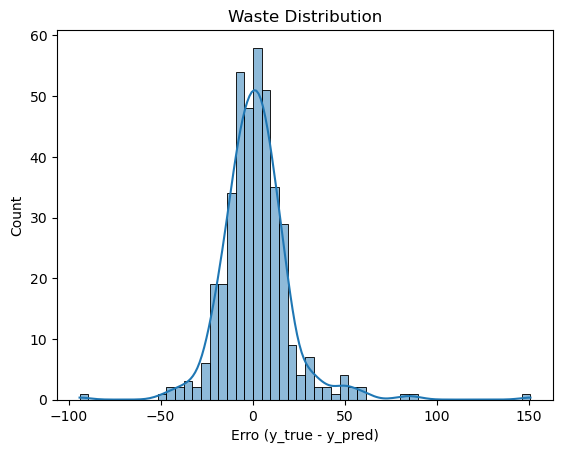

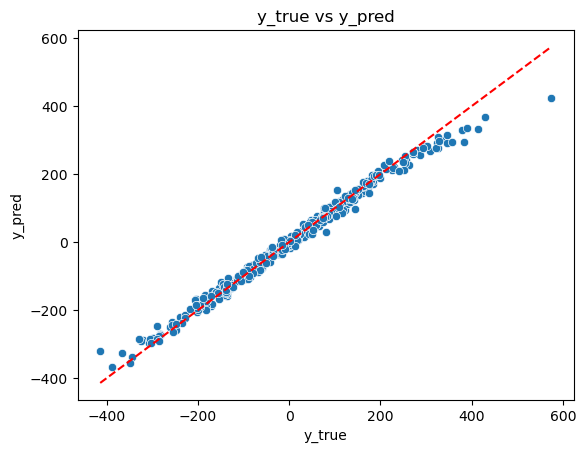

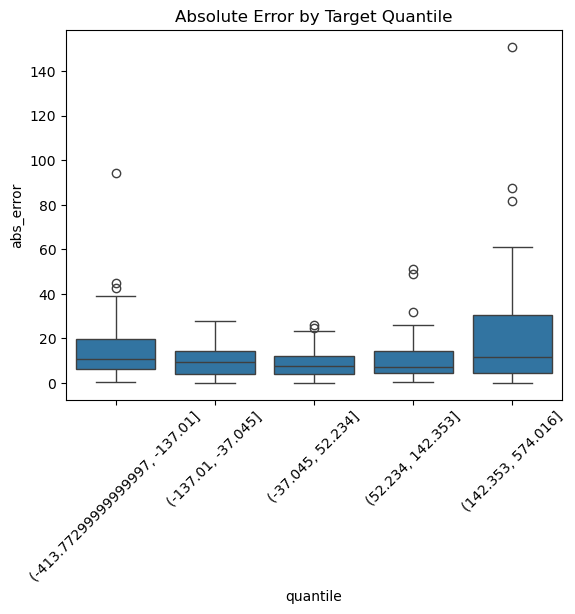

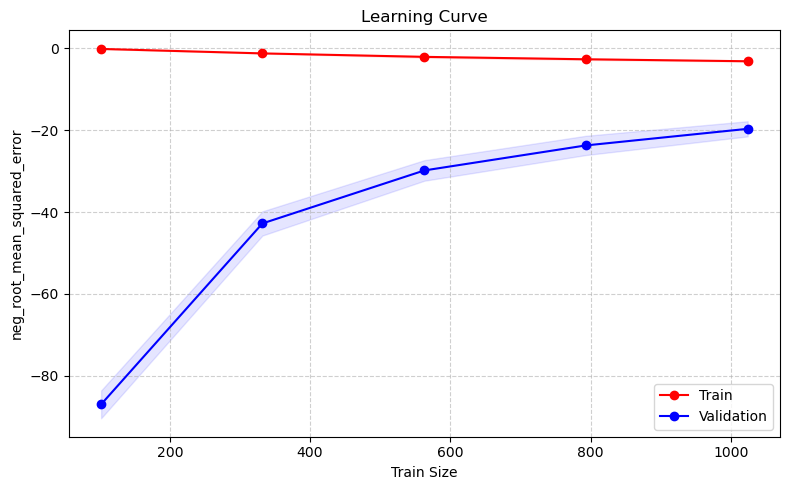

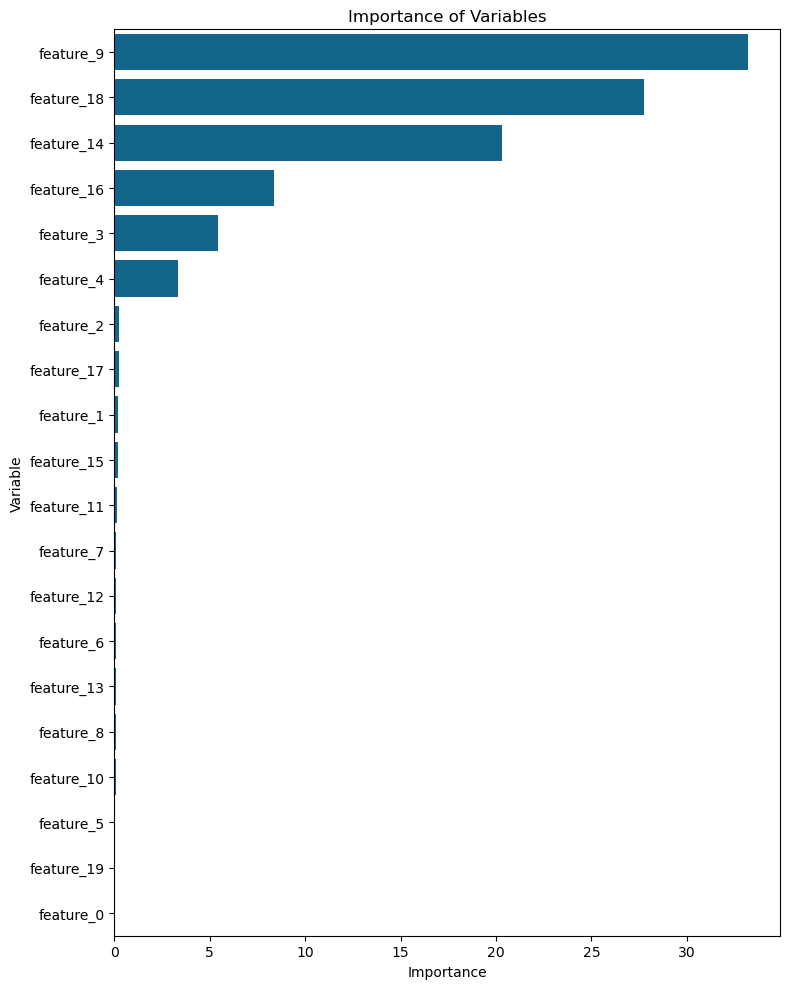

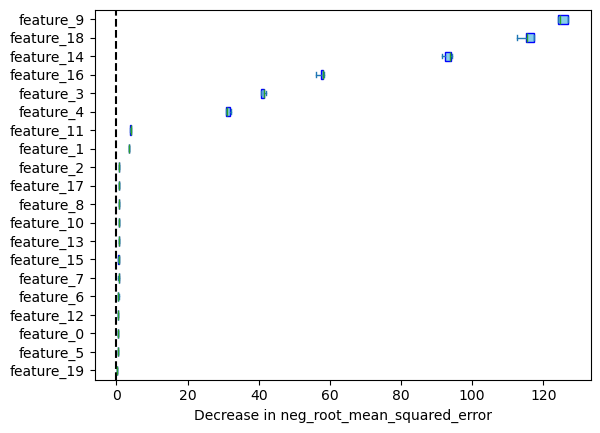

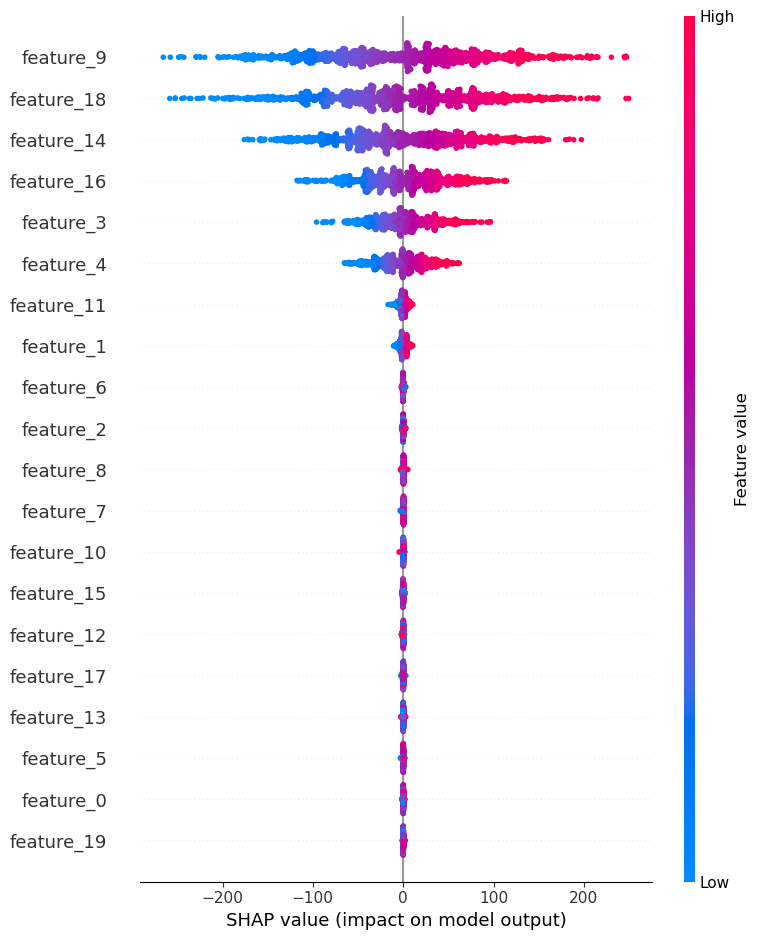

In [27]:
a.get_result_analysis()

## Feature Selection (CV)

In [28]:
a = AutoMLRegressor(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    model_name='LightGBM',
    target='target',
    scoring='root_mean_squared_error',
    features=best_features_reg
)

In [29]:
a.train()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 15
[LightGBM] [Info] Start training from score -9.323910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 15
[LightGBM] [Info] Start training from score -8.616114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 15
[LightGBM] [Info] Start trai

In [30]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.948581,26.527018,20.764729,0.846518,35.998336,0.948670
Test,0.958001,24.566306,18.522048,0.641994,33.330966,0.958369


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.948581,26.527018,20.764729,0.846518,35.998336,0.948670
Test,0.958001,24.566306,18.522048,0.641994,33.330966,0.958369


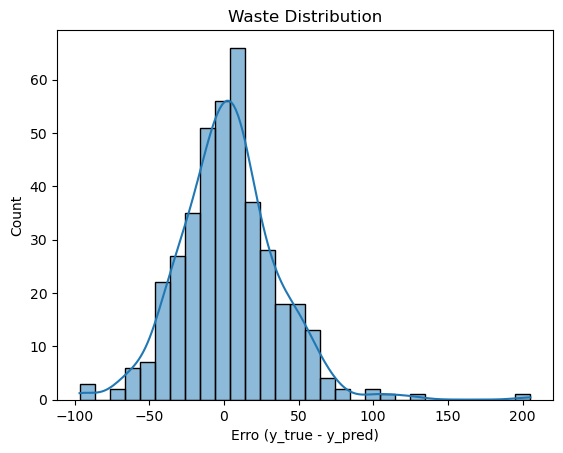

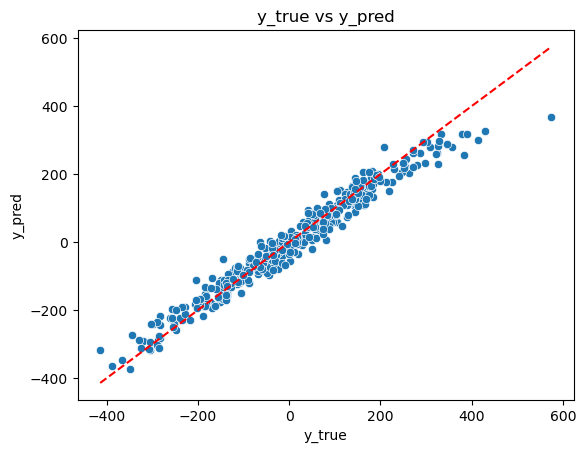

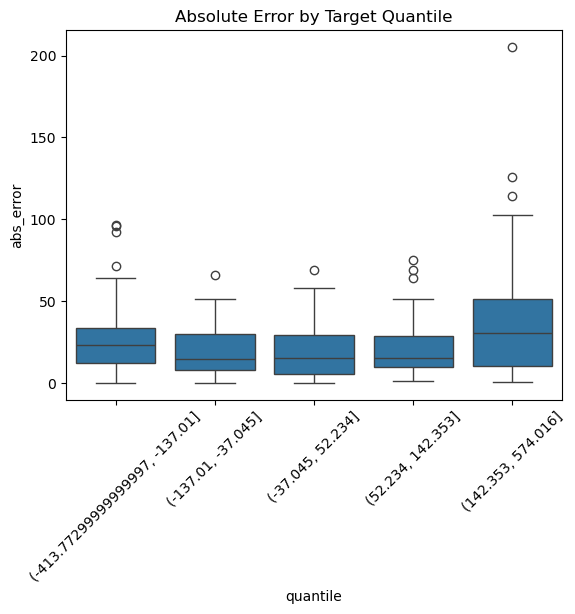

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713
[LightGBM] [Info] Number of data points in the train set: 102, number of used features: 20
[LightGBM] [Info] Start training from score 1.865394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

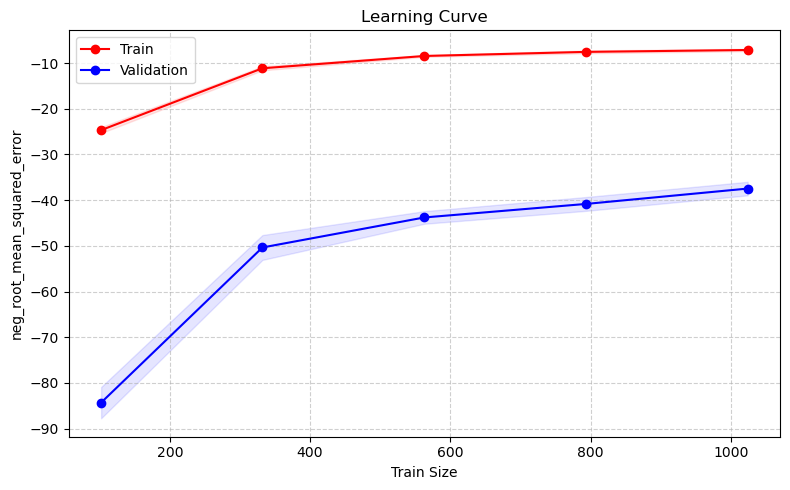

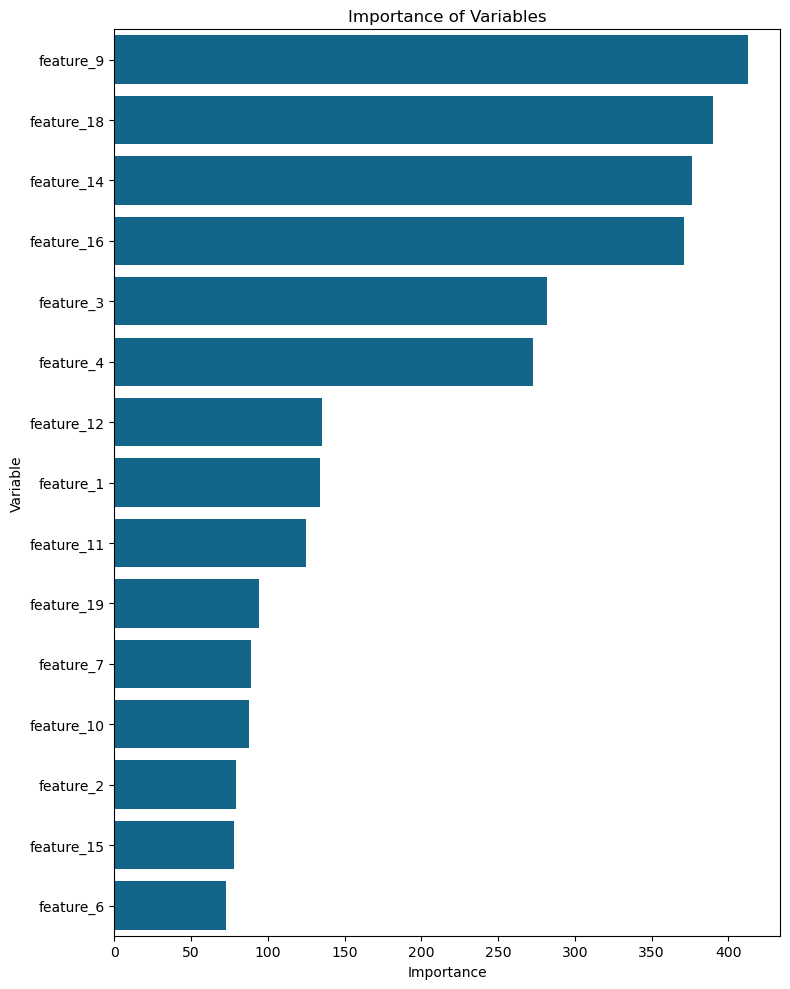

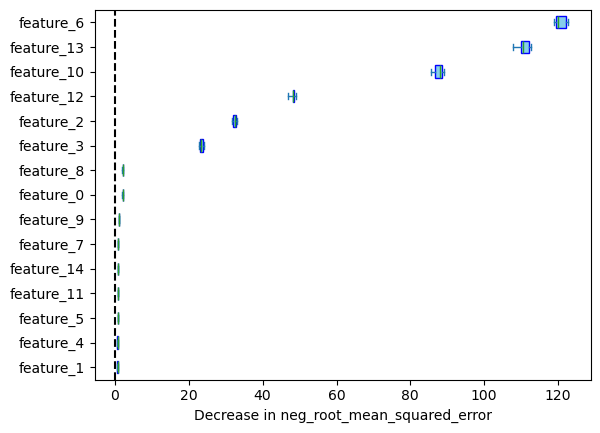

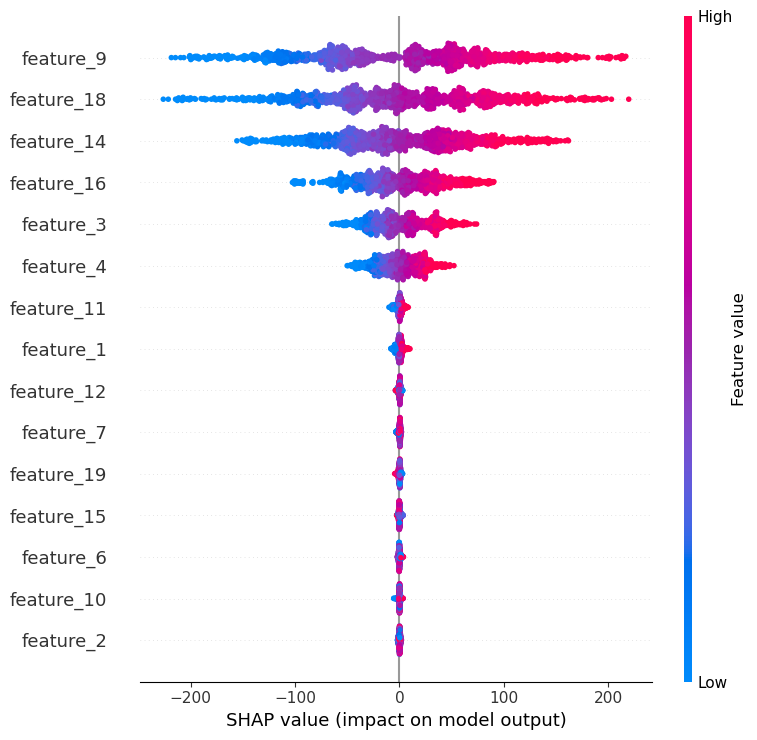

In [31]:
a.get_result_analysis()

## Hiperparameter Fine Tuning (CV)

In [12]:
a = AutoMLRegressor(
    X_train, 
    y_train,
    X_valid=None,
    y_valid=None,
    X_test=X_test,
    y_test=y_test,
    cv=5,
    tune=True,
    model_name='LightGBM',
    target='target',
    scoring='root_mean_squared_error',
    features=best_features_reg
)

In [13]:
a.train()

In [14]:
a.get_metrics()

,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.963772,21.410990,15.239322,1.127107,30.184939,0.963836
Test,0.972896,18.965083,14.311750,0.438830,26.775889,0.972943


,R2,MAE,MadAE,MAPE,RMSE,Explained Variance
Train CV,0.963772,21.410990,15.239322,1.127107,30.184939,0.963836
Test,0.972896,18.965083,14.311750,0.438830,26.775889,0.972943


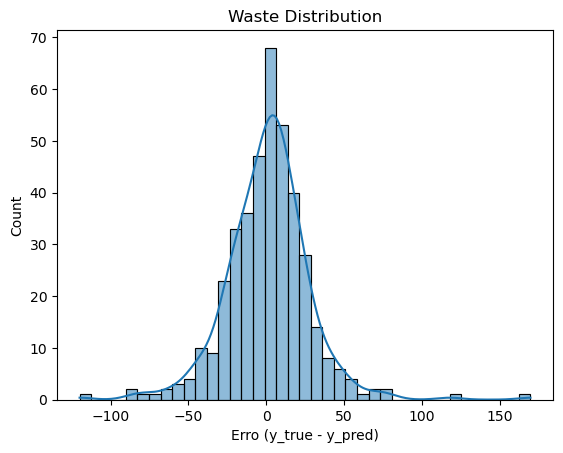

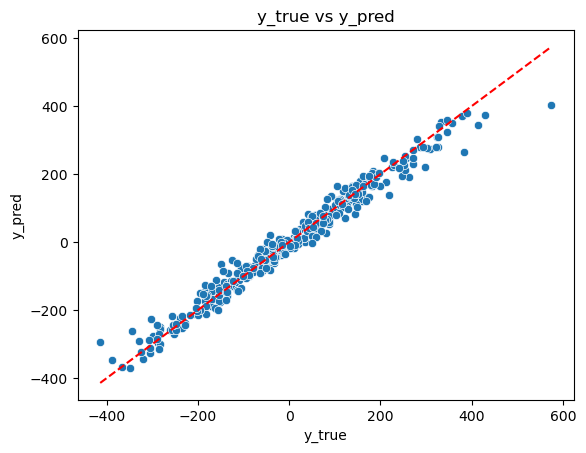

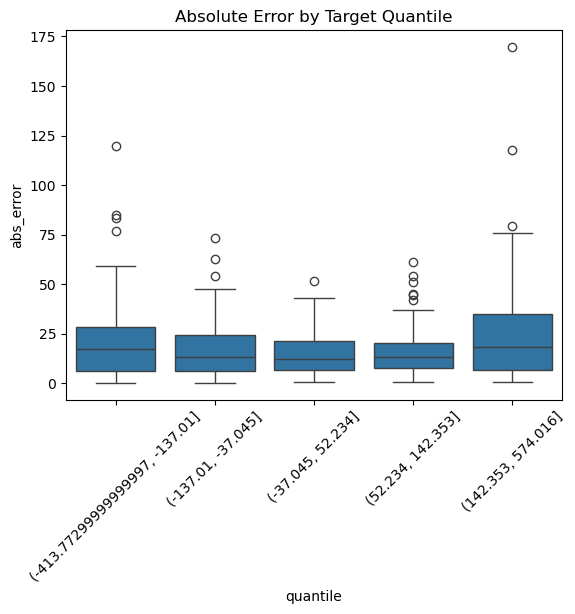

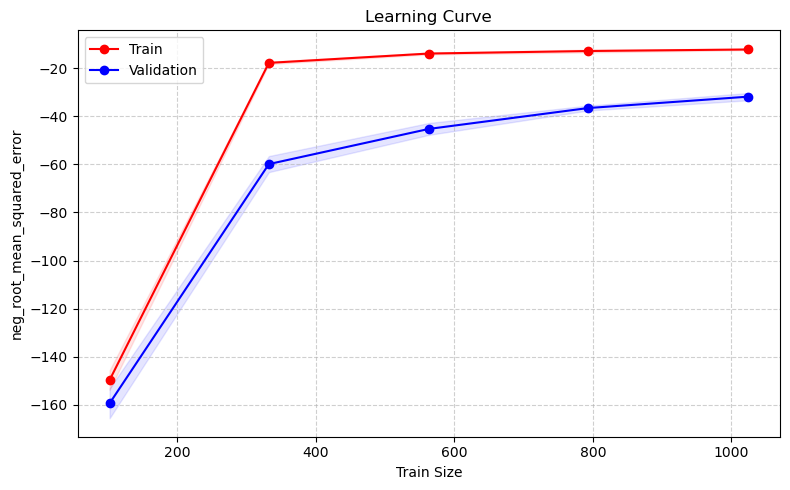

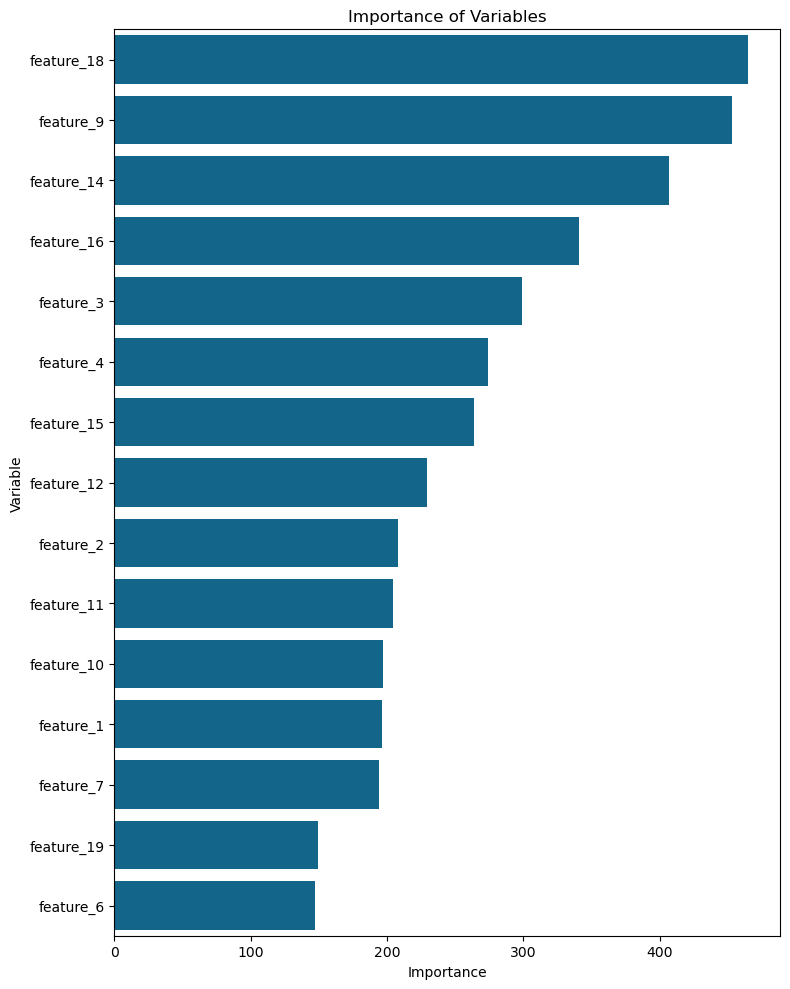

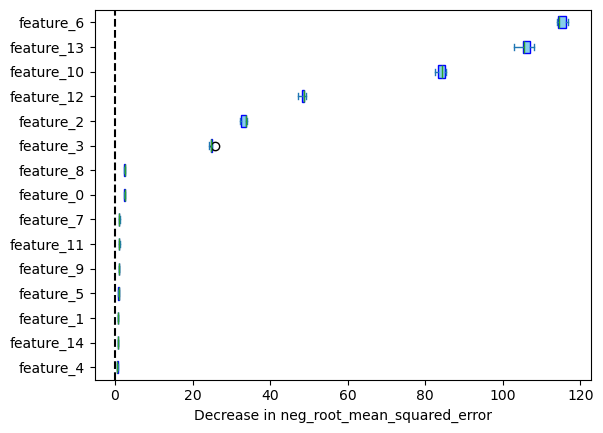

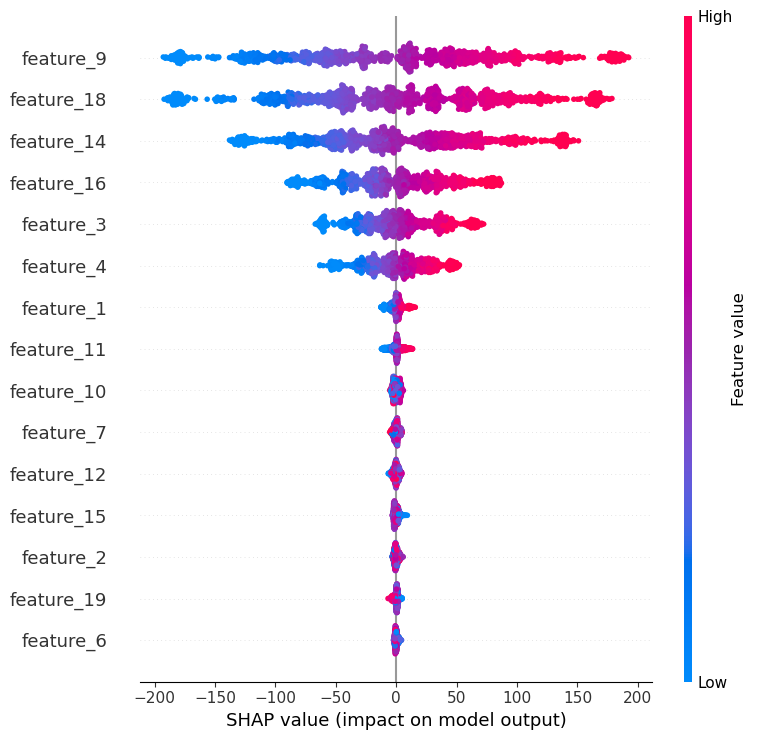

In [15]:
a.get_result_analysis()